In [1]:
#note to self to conda activate deepgen

In [1]:
import os.path as op
import os
import pandas as pd
import glob
import scipy.stats
import pickle
import numpy as np
import math
os.chdir('../')
import datastruct
import seaborn as sns
import matplotlib.pyplot as plt
import moss
from itertools import groupby  
import statsmodels.api as sm
from psychopy import data, gui, core
from psychopy.tools.filetools import fromFile
import pylab
import math
import statsmodels.formula.api as smf
%matplotlib inline

pygame 2.1.2 (SDL 2.0.18, Python 3.7.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%load_ext rpy2.ipython

In [3]:
#r stuff for Anovas
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects import r
base = importr('base')
afex = importr('afex') 

In [34]:
df = pd.read_csv('all_data_clean.csv')


#some renaming for figures
miniblock_map = {'rewarded':'rewarded rule',
                'noncompete':'unrewarded rules',
                'compete':'unrewarded rules'}
df['reward_block'] = [miniblock_map[x] for x in df['miniblock_type']]

df['Miniblock Type'] = df['miniblock_type']

coherence_map = {0.0:'Hard',1.0:'',2.0:' ',3.0:'Easy'}
df['Coherence'] = [coherence_map[x] for x in df['coherence_bin']]


tt_map = {'rewarded':'rewarded rule',
          'noncompete':'noncompeting rule',
         'compete':'competing rule'}

df['Trial Type '] = [tt_map[x] for x in df['miniblock_type']]
df['correct_bin'] = [int(x) for x in df['correct']]
df['correct_bin'] = [int(x) for x in df['correct']]
coherence = {'Hard':'Low',' ':' ','':'','Easy':'High'}
df['Coherence'] = [coherence[x] for x in df['Coherence']]

df = moss.remove_unit_variance(df, 'rt','sub','block')
df = moss.remove_unit_variance(df, 'correct','sub','block')
df['logRT'] = [np.log(x) for x in df['rt']]
df['Probability Correct'] = df['correct_within']
df['Reaction Time'] = df['rt_within']


df['coherence_center'] = df['coherence_bin'] - np.mean(df['coherence_bin'])


congruent = []
for features in zip(df['color'],
                               df['shape'],
                               df['motion']):
    
    if features ==  ('green','circle','up'):
        congruent.append('congruent')
        
    elif features ==  ('pink','cross','down'):
        congruent.append('congruent')

    else:
        congruent.append('incongruent')

df['congruency'] = congruent


train = df[df['block'] == 'reward']
test = df[df['block'] == 'test']

df.to_csv('all_data_clean.csv')
subs = list(set(df['sub']))
print(len(set(df['sub'])))

86


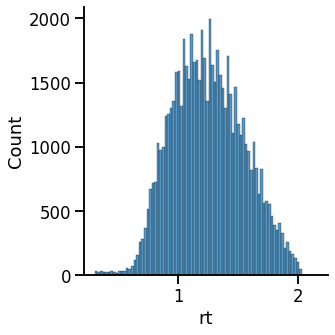

In [21]:
sns.displot(df['rt'])

# Rewarded rule analysis

## Accuracy

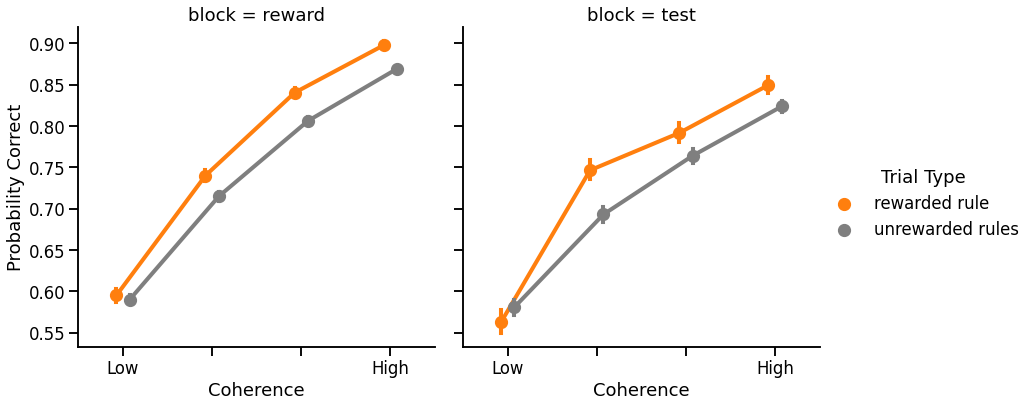

In [5]:
sns.set_context('talk')

df['Trial Type'] = df['reward_block']
sns.catplot(
        x="Coherence",
           y="Probability Correct",
           hue = "Trial Type",
                col = 'block',
            kind = 'point',
    hue_order = ['rewarded rule','unrewarded rules'],
        order = ['Low','',' ','High'],
        palette = [sns.color_palette(as_cmap = True)[1],
                   sns.color_palette(as_cmap = True)[7]],
            dodge = .15,
    height = 6,
    ci = 68,
           data=df)
plt.savefig(op.abspath('./paper/figs/rule_hab_acc.png'), dpi = 300)

In [6]:
%%R -i train
library(lme4)
library(lmerTest)
print(summary(glmer("correct_bin ~ coherence_center*relevel(factor(reward_block), ref='unrewarded rules') + (1 + coherence_center|sub)", 
                    family = 'binomial',
                    data=train)))

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: correct_bin ~ coherence_center * relevel(factor(reward_block),  
    ref = "unrewarded rules") + (1 + coherence_center | sub)
   Data: train

     AIC      BIC   logLik deviance df.resid 
 50971.1  51032.7 -25478.5  50957.1    49011 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.4996  0.1813  0.4258  0.6175  0.8829 

Random effects:
 Groups Name             Variance Std.Dev. Corr
 sub    (Intercept)      0.11047  0.3324       
        coherence_center 0.03294  0.1815   0.99
Number of obs: 49018, groups:  sub, 86

Fixed effects:
                                                                                      Estimate
(Intercept)                                                                            1.20104
coherence_center                                                                       0.55320
relevel(factor(reward_block), r

In [68]:
'reward',np.exp(0.17120)

('reward', 1.186728070902913)

In [84]:
'coherence',np.exp( 0.55320)

('coherence', 1.7388083112534725)

In [71]:
'interaction',np.exp( 0.09592)

('interaction', 1.1006710067911945)

In [15]:
%%R -i test
library(lme4)
library(lmerTest)
print(summary(glmer("correct_bin ~ coherence_center*relevel(factor(reward_block), ref='unrewarded rules')+ (1 + coherence_center|sub)", 
                    family = 'binomial',
                    data=test)))

R[write to console]: boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: correct_bin ~ coherence_center * relevel(factor(reward_block),  
    ref = "unrewarded rules") + (1 + coherence_center | sub)
   Data: test

     AIC      BIC   logLik deviance df.resid 
 17806.2  17859.9  -8896.1  17792.2    15959 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.9986 -1.1386  0.4671  0.6612  0.9540 

Random effects:
 Groups Name             Variance Std.Dev. Corr
 sub    (Intercept)      0.16326  0.4041       
        coherence_center 0.04268  0.2066   1.00
Number of obs: 15966, groups:  sub, 85

Fixed effects:
                                                                                      Estimate
(Intercept)                                                                            1.01606
coherence_center                                                                       0.44870
relevel(factor(reward_block), re

In [16]:
 np.exp(.144)

1.1548841085249135

In [87]:
np.exp(0.08936)

1.0934742362027348

## Reaction Time

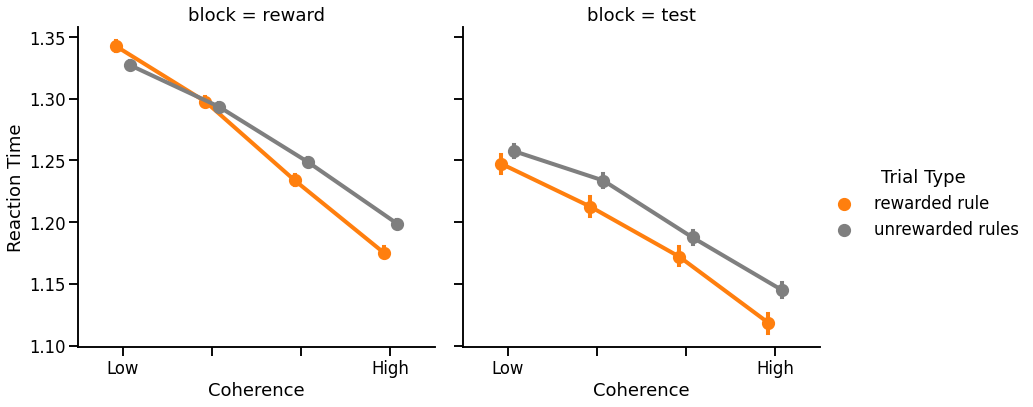

In [7]:
sns.catplot(
        x="Coherence",
           y="Reaction Time",
           hue = "Trial Type",
                col = 'block',
            kind = 'point',
    hue_order = ['rewarded rule','unrewarded rules'],
        order = ['Low','',' ','High'],
        palette = [sns.color_palette(as_cmap = True)[1],
                   sns.color_palette(as_cmap = True)[7]],
            dodge = .15,
    height = 6,
    ci = 68,
           data=df)
plt.savefig(op.abspath('./paper/figs/rule_hab_rt.png'), dpi = 300)

In [8]:
4.884e+04

48840.0

In [9]:
%%R -i train
library(lme4)
library(lmerTest)
print(summary(lmer("logRT ~ coherence_center*reward_block+ (1 + coherence_center|sub)", 
                    data=train)))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: "logRT ~ coherence_center*reward_block+ (1 + coherence_center|sub)"
   Data: train

REML criterion at convergence: -11255.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.7721 -0.6672  0.0482  0.7160  3.2341 

Random effects:
 Groups   Name             Variance  Std.Dev. Corr
 sub      (Intercept)      0.0093415 0.09665      
          coherence_center 0.0001987 0.01410  0.04
 Residual                  0.0460039 0.21449      
Number of obs: 49018, groups:  sub, 86

Fixed effects:
                                                Estimate Std. Error         df
(Intercept)                                    2.054e-01  1.056e-02  8.794e+01
coherence_center                              -4.664e-02  2.136e-03  1.891e+02
reward_blockunrewarded rules                   4.142e-03  2.055e-03  4.884e+04
coherence_center:reward_blockunrewarded rules  1.177e-02  1.838e-03  4.884e+04
        

In [15]:
np.exp(2.054e-01)*0.4150589937745863

0.5096991571890795

In [74]:
'reward',(np.exp(4.142e-03) - 1)*100

('reward', 0.4150589937745863)

In [83]:
'coherence_center',(1-np.exp(-4.664e-02))*100

('coherence_center', 4.556906911421333)

In [85]:
'reward',(np.exp(1.177e-02 ) - 1)*100

('reward', 1.183953900689838)

In [39]:
%%R -i test
library(lme4)
library(lmerTest)
print(summary(lmer("logRT ~ coherence_center*reward_block+ (1 + coherence_center|sub)", 
                    data=test)))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: "logRT ~ coherence_center*reward_block+ (1 + coherence_center|sub)"
   Data: test

REML criterion at convergence: 1162.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3163 -0.6507  0.0550  0.6937  5.1285 

Random effects:
 Groups   Name             Variance  Std.Dev. Corr 
 sub      (Intercept)      0.0243800 0.15614       
          coherence_center 0.0001225 0.01107  -0.64
 Residual                  0.0613377 0.24766       
Number of obs: 15966, groups:  sub, 85

Fixed effects:
                                                Estimate Std. Error         df
(Intercept)                                    1.272e-01  1.727e-02  8.799e+01
coherence_center                              -3.769e-02  3.268e-03  4.414e+02
reward_blockunrewarded rules                   1.712e-02  4.158e-03  1.580e+04
coherence_center:reward_blockunrewarded rules  6.268e-03  3.721e-03  1.580e+04
       

In [47]:
# range_coh = df['coherence_center'].max() - df['coherence_center'].min()
(np.exp(1.712e-02 ) - 1)*100

1.7267387087658959

In [50]:
'reward',(np.exp(1.177e-02 ) - 1)*100

15800.0

In [86]:
'reward',(np.exp(6.268e-03) - 1)*100

('reward', 0.6287685019074729)

# Miniblock Analysis

## Accuracy

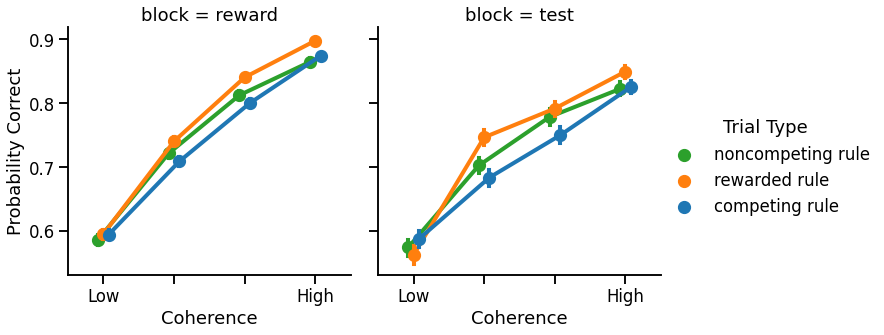

In [144]:
sns.catplot(
        x="Coherence",
           y="Probability Correct",
                col = 'block',
           hue = "Trial Type ",
#         hue_order = ['rewarded rule','competing rule','noncompeting rule'],
    order = ['Low','',' ','High'],
            kind = 'point',
            palette = [sns.color_palette(as_cmap = True)[2],
                    sns.color_palette(as_cmap = True)[1],
                   sns.color_palette(as_cmap = True)[0]],
            dodge = .15,
    ci = 68,
           data=df)

plt.savefig(op.abspath('./paper/figs/rule_hab_minibloc_acc.png'), dpi = 300)

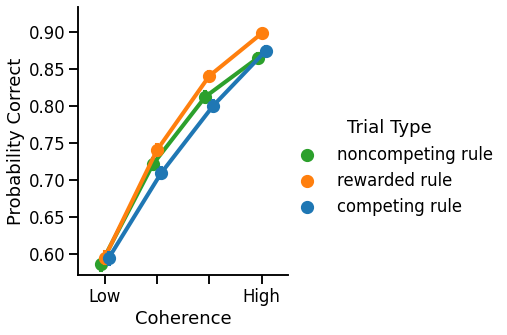

In [19]:
g = sns.catplot(
        x="Coherence",
           y="Probability Correct",
           hue = "Trial Type ",
    order = ['Low','',' ','High'],
            palette = [sns.color_palette(as_cmap = True)[2],
                    sns.color_palette(as_cmap = True)[1],
                   sns.color_palette(as_cmap = True)[0]],
            kind = 'point',
            dodge = .15,
    ci = 68,
           data=df[df.block == 'reward'])
g.set(ylim = (0.5711668628189077, 0.93390166251385)) ##from simulations
plt.savefig(op.abspath('./paper/figs/rule_hab_reward_acc.png'), dpi = 300)

In [110]:
%%R -i train
library(lme4)
library(lmerTest)
print(summary(glmer("correct_bin ~ coherence_center*miniblock_type+ (1 + coherence_center|sub)", 
                    family = 'binomial',
                    data=train)))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
correct_bin ~ coherence_center * miniblock_type + (1 + coherence_center |  
    sub)
   Data: train

     AIC      BIC   logLik deviance df.resid 
 50974.9  51054.1 -25478.5  50956.9    49009 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.4996  0.1818  0.4261  0.6175  0.8851 

Random effects:
 Groups Name             Variance Std.Dev. Corr
 sub    (Intercept)      0.11047  0.3324       
        coherence_center 0.03294  0.1815   0.99
Number of obs: 49018, groups:  sub, 86

Fixed effects:
                                           Estimate Std. Error z value Pr(>|z|)
(Intercept)                               1.1959361  0.0409150  29.230  < 2e-16
coherence_center                          0.5531168  0.0263580  20.985  < 2e-16
miniblock_typenoncompete                  0.0102235  0.0274821   0.372 0.709889
miniblock_typerewarded              

In [111]:
%%R -i test
library(lme4)
library(lmerTest)
print(summary(glmer("correct_bin ~ coherence_center*miniblock_type+ (1  + coherence_center|sub)", 
                    family = 'binomial',
                    data=test)))

R[write to console]: boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
correct_bin ~ coherence_center * miniblock_type + (1 + coherence_center |  
    sub)
   Data: test

     AIC      BIC   logLik deviance df.resid 
 17808.8  17877.9  -8895.4  17790.8    15957 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.9995 -1.1408  0.4690  0.6635  0.9765 

Random effects:
 Groups Name             Variance Std.Dev. Corr
 sub    (Intercept)      0.16331  0.4041       
        coherence_center 0.04269  0.2066   1.00
Number of obs: 15966, groups:  sub, 85

Fixed effects:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                                0.99198    0.05450  18.202  < 2e-16
coherence_center                           0.43337    0.03666  11.821  < 2e-16
miniblock_typenoncompete                   0.04854    0.04544   1.068 0.285414
miniblock_typerewarded                   

## Reaction time

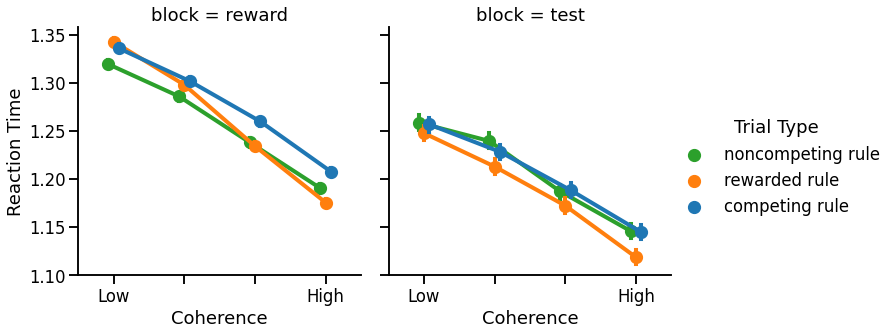

In [16]:
sns.catplot(
        x="Coherence",
           y="Reaction Time",
           hue = "Trial Type ",
                col = 'block',
            kind = 'point',
        order = ['Low','',' ','High'],
            palette = [sns.color_palette(as_cmap = True)[2],
                    sns.color_palette(as_cmap = True)[1],
                   sns.color_palette(as_cmap = True)[0]],
            dodge = .15,
    ci = 68,
           data=df)
plt.ylabel('LogRT')
plt.savefig(op.abspath('./paper/figs/rule_hab_rt_block.png'), dpi = 300)

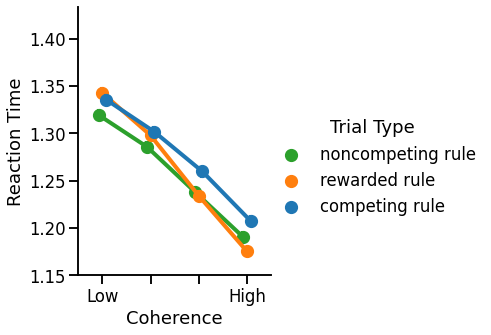

In [25]:
g = sns.catplot(
        x="Coherence",
           y="Reaction Time",
           hue = "Trial Type ",
            kind = 'point',
        order = ['Low','',' ','High'],
            palette = [sns.color_palette(as_cmap = True)[2],
                    sns.color_palette(as_cmap = True)[1],
                   sns.color_palette(as_cmap = True)[0]],
            dodge = .15,
    ci = 68,
           data=df[df.block == 'reward'])
g.set(ylim = (1.15, 1.433672978192678)) ##from simulations
plt.savefig(op.abspath('./paper/figs/rule_hab_rt_reward.png'), dpi = 300)

In [12]:
%%R -i train
library(lme4)
library(lmerTest)
print(summary(lmer("logRT ~ coherence_center*miniblock_type+ (1 + coherence_center|sub)", 
                    data=train)))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: "logRT ~ coherence_center*miniblock_type+ (1 + coherence_center|sub)"
   Data: train

REML criterion at convergence: -11273.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.8068 -0.6654  0.0478  0.7153  3.1995 

Random effects:
 Groups   Name             Variance  Std.Dev. Corr
 sub      (Intercept)      0.0093448 0.09667      
          coherence_center 0.0001987 0.01410  0.04
 Residual                  0.0459694 0.21440      
Number of obs: 49018, groups:  sub, 86

Fixed effects:
                                            Estimate Std. Error         df
(Intercept)                                2.169e-01  1.056e-02  8.792e+01
coherence_center                          -3.410e-02  2.136e-03  1.891e+02
miniblock_typenoncompete                  -1.464e-02  2.372e-03  4.884e+04
miniblock_typerewarded                    -1.147e-02  2.373e-03  4.884e+04
coherence_center:miniblock

In [93]:
'reward',(1-np.exp(-1.464e-02))*100

('reward', 1.4533356255765684)

In [13]:
%%R -i test
library(lme4)
library(lmerTest)
print(summary(lmer("logRT ~ coherence_center*miniblock_type+ (1  + coherence_center|sub)", 
                    data=test)))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: "logRT ~ coherence_center*miniblock_type+ (1  + coherence_center|sub)"
   Data: test

REML criterion at convergence: 1180.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3126 -0.6498  0.0552  0.6937  5.1284 

Random effects:
 Groups   Name             Variance  Std.Dev. Corr 
 sub      (Intercept)      0.0243768 0.15613       
          coherence_center 0.0001226 0.01107  -0.64
 Residual                  0.0613450 0.24768       
Number of obs: 15966, groups:  sub, 85

Fixed effects:
                                            Estimate Std. Error         df
(Intercept)                                1.437e-01  1.727e-02  8.803e+01
coherence_center                          -3.101e-02  3.268e-03  4.412e+02
miniblock_typenoncompete                   1.264e-03  4.802e-03  1.579e+04
miniblock_typerewarded                    -1.649e-02  4.804e-03  1.579e+04
coherence_center:miniblo

### Anovas

In [21]:
mod_data = train[train.miniblock_type != 'rewarded']
model = afex.aov_ez('sub', 'correct_bin', 
                    data = train, 
                    within=['coherence_center','miniblock_type'])
print(model)

# print(model.rx2('Anova'))

Anova Table (Type 3 tests)

Response: correct_bin
                           Effect           df  MSE          F  ges p.value
1                coherence_center 2.48, 210.87 0.01 709.52 *** .615   <.001
2                  miniblock_type 1.43, 121.47 0.01    6.44 ** .016    .006
3 coherence_center:miniblock_type 5.32, 451.99 0.00     2.09 + .006    .061
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1

Sphericity correction method: GG 



In [22]:
mod_data = test[test.miniblock_type != 'rewarded']

model = afex.aov_ez('sub', 'correct_bin', 
                    data = test, 
                    within=['coherence_bin','miniblock_type'])
print(model)

# print(model.rx2('Anova'))

Anova Table (Type 3 tests)

Response: correct_bin
                        Effect           df  MSE          F  ges p.value
1                coherence_bin 2.50, 210.29 0.02 215.18 *** .338   <.001
2               miniblock_type 1.87, 157.10 0.02     3.57 * .006    .033
3 coherence_bin:miniblock_type 5.34, 448.27 0.01     2.79 * .011    .015
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1

Sphericity correction method: GG 



In [23]:
model = afex.aov_ez('sub', 'correct_bin', 
                    data = df, 
                    within=['rule','coherence_bin'])
print(model)



Anova Table (Type 3 tests)

Response: correct_bin
              Effect           df  MSE          F  ges p.value
1               rule 1.73, 147.09 0.01  20.23 *** .059   <.001
2      coherence_bin 2.37, 201.37 0.01 794.39 *** .602   <.001
3 rule:coherence_bin 5.11, 434.32 0.00   4.96 *** .013   <.001
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1

Sphericity correction method: GG 



In [14]:
model = afex.aov_ez('sub', 'logRT', 
                    data = df, 
                    within=['rule','coherence_bin'])
print(model)




Anova Table (Type 3 tests)

Response: logRT
              Effect           df  MSE          F   ges p.value
1               rule 1.71, 145.60 0.01       0.06 <.001    .918
2      coherence_bin 1.95, 165.74 0.00 342.86 ***  .122   <.001
3 rule:coherence_bin 4.70, 399.71 0.00  29.16 ***  .015   <.001
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1

Sphericity correction method: GG 



In [15]:
model = afex.aov_ez('sub', 'logRT', data = train, within=['coherence_bin','miniblock_type'])
print(model)

# print(model.rx2('Anova'))

Anova Table (Type 3 tests)

Response: logRT
                        Effect           df  MSE          F  ges p.value
1                coherence_bin 1.96, 166.90 0.00 327.22 *** .140   <.001
2               miniblock_type 1.25, 105.87 0.01     2.83 + .003    .087
3 coherence_bin:miniblock_type 4.13, 351.33 0.00   5.65 *** .003   <.001
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1

Sphericity correction method: GG 



In [18]:
model = afex.aov_ez('sub', 'logRT', data = test, within=['coherence_bin','miniblock_type'])
print(model)

Anova Table (Type 3 tests)

Response: logRT
                        Effect           df  MSE         F   ges p.value
1                coherence_bin 2.88, 241.68 0.01 98.00 ***  .047   <.001
2               miniblock_type 1.78, 149.25 0.01    3.77 *  .002    .030
3 coherence_bin:miniblock_type 5.21, 438.03 0.00      0.72 <.001    .611
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1

Sphericity correction method: GG 



# Switch Analysis

In [59]:

mod = smf.mixedlm('rt ~ miniblock_type + coherence_center',
                  re_formula = '~coherence_center',
            groups = 'sub',
           data = train).fit()
train['rt_resid'] = mod.resid+ train['rt'].mean()
train = moss.remove_unit_variance(train, 'rt_resid','sub')


mod = smf.mixedlm('rt ~ miniblock_type + coherence_center',
                                    re_formula = '~coherence_center',
            groups = 'sub',
           data = test).fit()
test['rt_resid'] = mod.resid + test['rt'].mean()
test = moss.remove_unit_variance(test, 'rt_resid','sub')



df_mod = pd.concat([train,test])

/Users/ianballard/anaconda3/envs/deepgen/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/ianballard/anaconda3/envs/deepgen/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


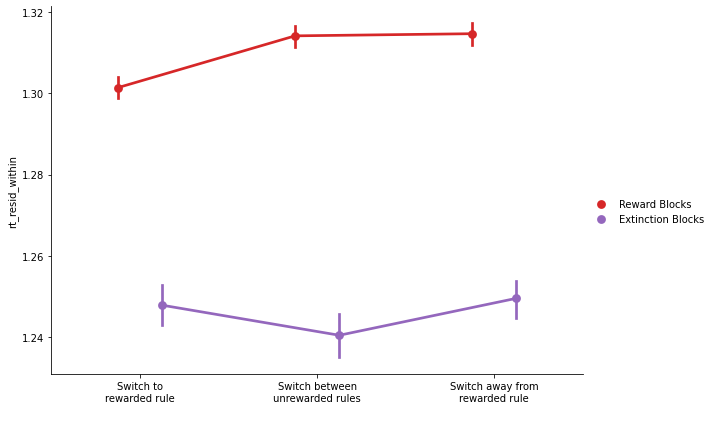

In [60]:
sub_df = df_mod[df_mod['switch_type'] != 'stay']

switch_map = {'switch_to':'Switch to\nrewarded rule',
             'switch_away':'Switch away from\nrewarded rule',
             'switch_other':'Switch between\nunrewarded rules'}
sub_df['    '] = [switch_map[x] for x in sub_df['switch_type']]

block_map = {'reward':'Reward Blocks',
            'test':'Extinction Blocks'}
sub_df[''] = [block_map[x] for x in sub_df['block']]
sns.catplot(x = '    ',
             y = 'rt_resid_within',
              join = True,
            hue = '',
            order = ['Switch to\nrewarded rule','Switch between\nunrewarded rules','Switch away from\nrewarded rule'],
#             size=10,
              dodge = .25,
            aspect = 1.4,
            height = 6,
            ci = 68,
            palette = [sns.color_palette(as_cmap = True)[3],
                   sns.color_palette(as_cmap = True)[4]],
            kind = 'point',
           data=sub_df)

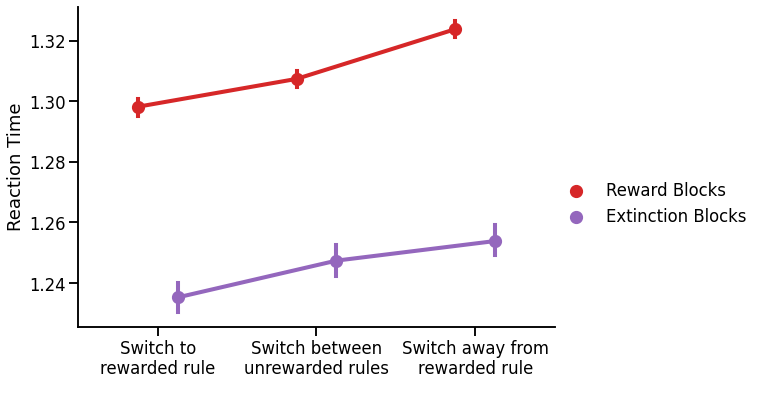

In [28]:
sub_df = df[df['switch_type'] != 'stay']

switch_map = {'switch_to':'Switch to\nrewarded rule',
             'switch_away':'Switch away from\nrewarded rule',
             'switch_other':'Switch between\nunrewarded rules'}
sub_df['    '] = [switch_map[x] for x in sub_df['switch_type']]

block_map = {'reward':'Reward Blocks',
            'test':'Extinction Blocks'}
sub_df[''] = [block_map[x] for x in sub_df['block']]

sns.catplot(x = '    ',
             y = 'Reaction Time',
              join = True,
            hue = '',
            order = ['Switch to\nrewarded rule','Switch between\nunrewarded rules','Switch away from\nrewarded rule'],
#             size=10,
              dodge = .25,
            aspect = 1.4,
            height = 6,
            ci = 68,
            y_partial = 'miniblock_type',
            palette = [sns.color_palette(as_cmap = True)[3],
                   sns.color_palette(as_cmap = True)[4]],
            kind = 'point',
           data=sub_df)
plt.savefig(op.abspath('./paper/figs/switch_rt.png'), dpi = 300)

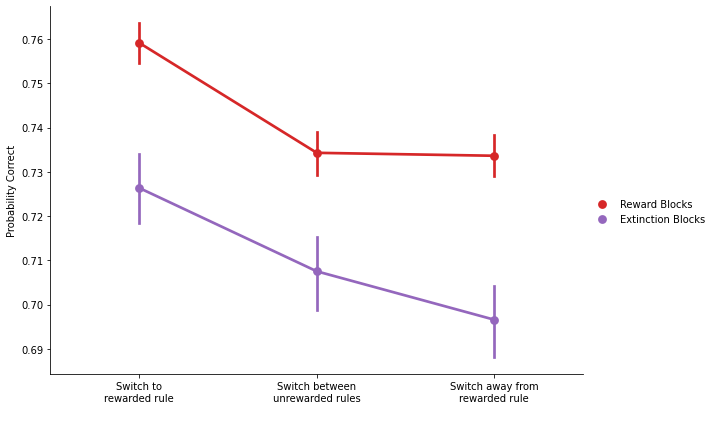

In [62]:
sub_df = df[df['switch_type'] != 'stay']

switch_map = {'switch_to':'Switch to\nrewarded rule',
             'switch_away':'Switch away from\nrewarded rule',
             'switch_other':'Switch between\nunrewarded rules'}
sub_df['    '] = [switch_map[x] for x in sub_df['switch_type']]

block_map = {'reward':'Reward Blocks',
            'test':'Extinction Blocks'}
sub_df[''] = [block_map[x] for x in sub_df['block']]

sns.catplot(x = '    ',
             y = 'Probability Correct',
              join = True,
            hue = '',
            order = ['Switch to\nrewarded rule','Switch between\nunrewarded rules','Switch away from\nrewarded rule'],
#             size=10,
#               dodge = .25,
            x_partial = 'miniblock_type',
            aspect = 1.4,
            height = 6,
            ci = 68,
            palette = [sns.color_palette(as_cmap = True)[3],
                   sns.color_palette(as_cmap = True)[4]],
            kind = 'point',
#             ax = ax,
           data=sub_df)
plt.savefig(op.abspath('./paper/figs/switch_acc.png'), dpi = 300)

In [94]:
mod_df = df#[df['switch_type'] != 'stay']
mod_df = mod_df[mod_df['block'] == 'reward'].dropna(subset = ['rt'])

In [95]:
%%R -i mod_df
library(lme4)
library(lmerTest)

print(summary(lmer("logRT ~ coherence_center + relevel(factor(miniblock_type), ref='noncompete')  + relevel(factor(switch_type), ref='switch_other') + (1 |sub)",
                   REML =FALSE,
                   data=mod_df)))

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: 
"logRT ~ coherence_center + relevel(factor(miniblock_type), ref='noncompete')  + relevel(factor(switch_type), ref='switch_other') + (1 |sub)"
   Data: mod_df

     AIC      BIC   logLik deviance df.resid 
-13205.3 -13126.1   6611.6 -13223.3    49009 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.9009 -0.6806  0.0333  0.7173  3.5393 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.009321 0.09654 
 Residual             0.044332 0.21055 
Number of obs: 49018, groups:  sub, 86

Fixed effects:
                                                                Estimate
(Intercept)                                                    2.443e-01
coherence_center                                              -3.921e-02
relevel(factor(miniblock_type), ref = "noncompete")compete     1.505e-02
relevel(factor(miniblock_type), ref = "noncompete")

In [98]:
'reward',(1-np.exp(-2.477e-02))*100

('reward', 2.4465740892975707)

In [30]:
mod_df = df
mod_df = mod_df[mod_df['block'] == 'test'].dropna(subset = ['rt'])

In [97]:
%%R -i mod_df
library(lme4)
library(lmerTest)

print(summary(lmer("logRT ~ coherence_center + relevel(factor(miniblock_type), ref='noncompete') + relevel(factor(switch_type), ref='switch_other')+ (1 |sub)",
                   REML = FALSE,
                   data=mod_df)))

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: 
"logRT ~ coherence_center + relevel(factor(miniblock_type), ref='noncompete') + relevel(factor(switch_type), ref='switch_other')+ (1 |sub)"
   Data: mod_df

     AIC      BIC   logLik deviance df.resid 
   563.9    633.0   -273.0    545.9    15957 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5709 -0.6508  0.0468  0.6800  5.2902 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.02412  0.1553  
 Residual             0.05920  0.2433  
Number of obs: 15966, groups:  sub, 85

Fixed effects:
                                                                Estimate
(Intercept)                                                    1.820e-01
coherence_center                                              -3.425e-02
relevel(factor(miniblock_type), ref = "noncompete")compete    -9.656e-03
relevel(factor(miniblock_type), ref = "noncompete")re

In [100]:
'reward',(np.exp(1.881e-02)-1)*100
1.448e-02

('reward', 1.898802249923448)

In [101]:
'reward',(np.exp(1.448e-02)-1)*100


('reward', 1.4585343041619403)

In [23]:
%%R -i mod_df
library(lme4)
library(lmerTest)

print(summary(lmer("logRT ~ coherence_center + miniblock_type + relevel(factor(switch_type), ref='switch_other')+ (1 + coherence_center|sub)", 
                   data=mod_df)))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
"rt ~ coherence_center + miniblock_type + relevel(factor(switch_type), ref='switch_other')+ (1 + coherence_center|sub)"
   Data: mod_df

REML criterion at convergence: 4240.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5292 -0.7190 -0.0614  0.6547  4.3827 

Random effects:
 Groups   Name             Variance  Std.Dev. Corr 
 sub      (Intercept)      0.0250970 0.15842       
          coherence_center 0.0002305 0.01518  -0.69
 Residual                  0.0743200 0.27262       
Number of obs: 15966, groups:  sub, 85

Fixed effects:
                                                                Estimate
(Intercept)                                                    1.232e+00
coherence_center                                              -4.012e-02
miniblock_typenoncompete                                       1.405e-02
miniblock_typerewarded                                 

In [88]:
mod_df = df#[df['switch_type'] != 'stay']
# mod_df = mod_df[mod_df['switch_type'] != 'switch_other']
mod_df = mod_df[mod_df['block'] == 'test']

In [25]:
%%R -i mod_df
library(lme4)
library(lmerTest)

print(summary(lmer("logRT ~ coherence_center + miniblock_type + relevel(factor(switch_type), ref='switch_other')  + (1 + coherence_center|sub)", 
                    data=mod_df)))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
"logRT ~ coherence_center + miniblock_type + relevel(factor(switch_type), ref='switch_other')  + (1 + coherence_center|sub)"
   Data: mod_df

REML criterion at convergence: 589.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5591 -0.6487  0.0431  0.6796  5.1032 

Random effects:
 Groups   Name             Variance  Std.Dev. Corr 
 sub      (Intercept)      0.0243865 0.15616       
          coherence_center 0.0001192 0.01092  -0.64
 Residual                  0.0590841 0.24307       
Number of obs: 15966, groups:  sub, 85

Fixed effects:
                                                                Estimate
(Intercept)                                                    1.723e-01
coherence_center                                              -3.402e-02
miniblock_typenoncompete                                       9.728e-03
miniblock_typerewarded                             

## Accuracy

In [66]:

mod_df = df#[df['switch_type'] != 'stay']
mod_df = mod_df[mod_df['block'] == 'reward']

In [68]:
%%R -i mod_df
library(lme4)
library(lmerTest)

print(summary(glmer("correct_bin ~ coherence_center + miniblock_type + relevel(factor(switch_type), ref='switch_other')  + (1 + coherence_center + miniblock_type + relevel(factor(switch_type), ref='switch_other')|sub)", 
                    family = 'binomial',
                    data=mod_df)))

From cffi callback <function _processevents at 0x7fb0c3c81e18>:
Traceback (most recent call last):
  File "/Users/ianballard/anaconda3/envs/deepgen/lib/python3.7/site-packages/rpy2/rinterface_lib/callbacks.py", line 275, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x7fb0c3c81e18>:
Traceback (most recent call last):
  File "/Users/ianballard/anaconda3/envs/deepgen/lib/python3.7/site-packages/rpy2/rinterface_lib/callbacks.py", line 275, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x7fb0c3c81e18>:
Traceback (most recent call last):
  File "/Users/ianballard/anaconda3/envs/deepgen/lib/python3.7/site-packages/rpy2/rinterface_lib/callbacks.py", line 275, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x7fb0c3c81e18>:
Tra

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
correct_bin ~ coherence_center + miniblock_type + relevel(factor(switch_type),  
    ref = "switch_other") + (1 + coherence_center + miniblock_type +  
    relevel(factor(switch_type), ref = "switch_other") | sub)
   Data: mod_df

     AIC      BIC   logLik deviance df.resid 
 50813.6  51121.6 -25371.8  50743.6    48983 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.4685  0.1737  0.4216  0.6172  1.1093 

Random effects:
 Groups Name                                                          Variance
 sub    (Intercept)                                                   0.11305 
        coherence_center                                              0.03349 
        miniblock_typenoncompete                                      0.00409 
        miniblock_typerewarded                                        0.23253 
        relevel(factor(switch_

In [69]:
mod_df = df#[df['switch_type'] != 'stay']
mod_df = mod_df[mod_df['block'] == 'test']

In [70]:
%%R -i mod_df
library(lme4)
library(lmerTest)

print(summary(glmer("correct_bin ~ coherence_center + miniblock_type + relevel(factor(switch_type), ref='switch_other')  + (1 + coherence_center + miniblock_type + relevel(factor(switch_type), ref='switch_other')|sub)", 
                    family = 'binomial',
                    data=mod_df)))

R[write to console]: boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
correct_bin ~ coherence_center + miniblock_type + relevel(factor(switch_type),  
    ref = "switch_other") + (1 + coherence_center + miniblock_type +  
    relevel(factor(switch_type), ref = "switch_other") | sub)
   Data: mod_df

     AIC      BIC   logLik deviance df.resid 
 17835.3  18104.0  -8882.6  17765.3    15931 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.1786 -1.0903  0.4679  0.6700  1.2554 

Random effects:
 Groups Name                                                          Variance
 sub    (Intercept)                                                   0.00000 
        coherence_center                                              0.03967 
        miniblock_typenoncompete                                      0.04561 
        miniblock_typerewarded                                        0.18508 
        relevel(factor(switch_

In [126]:
# mod_df = df[df['switch_type'] != 'stay']
# mod_df = mod_df[mod_df['switch_type'] != 'switch_other']
# mod_df = mod_df[mod_df['block'] == 'reward']

In [87]:
# %%R -i mod_df
# library(lme4)
# library(lmerTest)

# print(summary(glmer("correct_bin ~ coherence_center + switch_type  + (1 + coherence_center|sub)", 
#                     family = 'binomial',
#                     data=mod_df)))

In [128]:
mod_df = df[df['switch_type'] != 'stay']
mod_df = mod_df[mod_df['switch_type'] != 'switch_other']
mod_df = mod_df[mod_df['block'] == 'test']

In [129]:
%%R -i mod_df
library(lme4)
library(lmerTest)

print(summary(glmer("correct_bin ~ coherence_center + switch_type  + (1 + coherence_center|sub)", 
                    family = 'binomial',
                    data=mod_df)))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
correct_bin ~ coherence_center + switch_type + (1 + coherence_center |  
    sub)
   Data: mod_df

     AIC      BIC   logLik deviance df.resid 
  6914.0   6954.3  -3451.0   6902.0     6054 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9892 -1.1105  0.4763  0.6806  1.0278 

Random effects:
 Groups Name             Variance Std.Dev. Corr
 sub    (Intercept)      0.2172   0.4661       
        coherence_center 0.0466   0.2159   0.92
Number of obs: 6060, groups:  sub, 85

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)           0.92523    0.06606  14.006  < 2e-16 ***
coherence_center      0.45279    0.03669  12.341  < 2e-16 ***
switch_typeswitch_to  0.15804    0.05893   2.682  0.00732 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (

# Odds and ends

In [39]:
%%R -i train
library(lme4)
library(lmerTest)
print(summary(lmer("logrt ~ coherence_center  + reward_block*congruency + (1 + coherence_center|sub)", 
                    data=train)))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
"logrt ~ coherence_center  + reward_block*congruency + (1 + coherence_center|sub)"
   Data: train

REML criterion at convergence: -11216

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.7767 -0.6681  0.0499  0.7160  3.2336 

Random effects:
 Groups   Name             Variance  Std.Dev. Corr
 sub      (Intercept)      0.0093433 0.09666      
          coherence_center 0.0001989 0.01410  0.04
 Residual                  0.0460338 0.21455      
Number of obs: 49018, groups:  sub, 86

Fixed effects:
                                                     Estimate Std. Error
(Intercept)                                         2.143e-01  1.094e-02
coherence_center                                   -3.877e-02  1.751e-03
reward_blockunrewarded rules                       -2.842e-03  4.093e-03
congruencyincongruent                              -1.184e-02  3.865e-03
reward_blockunrewarded r

In [46]:
np.exp(9.360e-03) - 1

0.009403941791385595

In [43]:
'reward',(np.exp(9.360e-03) - 1)*100

('reward', 0.9403941791385595)

In [40]:
%%R -i test
library(lme4)
library(lmerTest)
print(summary(lmer("logrt ~ coherence_center  + reward_block*congruency + (1 + coherence_center|sub)", 
                    data=test)))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
"logrt ~ coherence_center  + reward_block*congruency + (1 + coherence_center|sub)"
   Data: test

REML criterion at convergence: 1171.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3295 -0.6513  0.0546  0.6938  5.1477 

Random effects:
 Groups   Name             Variance  Std.Dev. Corr 
 sub      (Intercept)      0.0243956 0.15619       
          coherence_center 0.0001234 0.01111  -0.64
 Residual                  0.0613467 0.24768       
Number of obs: 15966, groups:  sub, 85

Fixed effects:
                                                     Estimate Std. Error
(Intercept)                                         1.291e-01  1.823e-02
coherence_center                                   -3.351e-02  2.128e-03
reward_blockunrewarded rules                        1.978e-02  8.295e-03
congruencyincongruent                              -2.528e-03  7.805e-03
reward_blockunrewarde